# Abstract

## Table of Contents
1. [Introduction](#section1)
2. [Importing and Cleaning Data](#section2)
3. [Exploratory Data Analysis](#section3)

<a id='section1'></a>
## Introduction

<a id='section2'></a>
## Importing and Cleaning Data

In [98]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from random import shuffle
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual
from scipy.signal import welch, periodogram
from librosa.feature import zero_crossing_rate
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.stats import gaussian_kde
from matplotlib.ticker import MultipleLocator
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
import pywt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

I'll preview the data first.

In [3]:
features = pd.read_csv('X_train.csv')
target = pd.read_csv('y_train.csv')
df = pd.merge(target, features, how = 'outer', left_on = 'series_id', right_on = 'series_id')

In [4]:
df.tail()

,series_id,group_id,surface,row_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
487675,3809,56,soft_pvc,3809_123,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.14274,3.27180,2.0115,-9.0063
487676,3809,56,soft_pvc,3809_124,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.13238,4.42750,3.0696,-8.1257
487677,3809,56,soft_pvc,3809_125,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.13894,2.70480,4.2622,-8.1443
487678,3809,56,soft_pvc,3809_126,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.13021,2.54100,4.7130,-9.4435
487679,3809,56,soft_pvc,3809_127,127,0.62915,-0.76839,-0.084441,0.081284,-0.042769,0.034049,-0.12580,0.82391,4.2751,-10.4980


In [ ]:
features.groupby('series_id').mean().describe()

In [5]:
surfaces = list(df.surface.unique())
features = list(df.columns[9:])

Since the data was recorded in groups, it is helpful to stitch it back together in order to better differentiate the underlying signals and upsample to increase the amount of training data. Upsampling can be done by slicing the data for 128 samples at every interval, since the original slicing was arbitrary to begin with.
Stitching the data will also help to understand the holistic motion of the robot.

The graph below shows how the data can stitched using location cues. Series are stitched together so that the last entry of a series in an orientation is continuous with the first entry of the same orientation in a different series. This is equivalent to moving the lines below so that they they form one continuous line.

In [ ]:
g = df.groupby(by = 'group_id')
g67 = g.get_group(67)
g67_g = g67.groupby('series_id')
f, axes = plt.subplots(2, 2, figsize = (12,8))
axs = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]
orientations = ['orientation_X','orientation_Y','orientation_Z','orientation_W']
for name, group in g67_g:
    for ax,orientation in zip(axs,orientations):
        group[orientation].plot(label = name, ax=ax, title = orientation)

In [6]:
def find_matches(current_signal, df, in_front = True, threshold = 0.01):
    ## Returns a dataframe of the series ids, sums, and position (front/end) of the likely matches for the given front and end values.
    orientations = ['orientation_X','orientation_Y','orientation_Z','orientation_W']
    selection = ['series_id'] + orientations
    if in_front:
        end = current_signal.iloc[127][selection]
        front = df.loc[df.measurement_number ==0][selection]
    else:
        front = current_signal.iloc[0][selection]
        end = df.loc[df.measurement_number ==127][selection]
    compare = (front-end).abs()
    if in_front:
        compare.series_id = front.series_id
    else:
        compare.series_id = end.series_id
    compare['sums'] = compare[orientations].sum(axis=1)
    compare['in_front'] = in_front
    compare.drop(labels = orientations, axis = 1, inplace = True)
    compare.sort_values(by = 'sums', inplace = True)
    if any(compare.sums < threshold):
        return compare.loc[compare.sums < threshold], True
    else:
        return 0,False

In [ ]:
series = 0
signal = df.loc[df.series_id==series]
candidates,match = find_matches(signal, df.loc[df.series_id != series], in_front = True)
candidates

In [7]:
def continuity(current_signal, compare_signal, in_front = True, merge_threshold = 4, slope_threshold = 6):
    orientations = ['orientation_X','orientation_Y','orientation_Z','orientation_W']
    select = ['series_id'] + orientations
    if in_front:
        end = current_signal[select]
        front = compare_signal[select]
    else:
        front = current_signal[select]
        end = compare_signal[select]
    stitched = pd.concat([end,front])
    diff = stitched.diff()
    
    # Check for continuity based on difference at merge point
    mean = diff[orientations].iloc[120:127].mean()
    std = diff[orientations].iloc[120:127].std()
    test = (diff[orientations].iloc[128]-mean)/std
    if any(test.abs() > merge_threshold):
        return False
    
    # Check for continuity based on slopes (t-test of means)
    slope_front = diff[orientations].iloc[120:127].mean()
    std_front = diff[orientations].iloc[120:127].std()
    var_front = std_front.apply(np.square)
    slope_end = diff[orientations].iloc[129:136].mean()
    std_end = diff[orientations].iloc[129:136].std()
    var_end = std_end.apply(np.square)
    t_value = (slope_front-slope_end)/(var_front/8+var_end/8).apply(np.sqrt)
    if any(t_value.abs() > slope_threshold):
        return False
    
    return True
current_signal = df.loc[df.series_id==47]
compare_signal = df.loc[df.series_id==92]
continuity(current_signal,compare_signal, in_front = True)

True

In [8]:
def group_series(df, match_threshold = 0.01, continuity_thresholds = (4,6)):
    df_c = df.copy()
    # Create variables
    lookup_dictionary = {}
    new_group_id = -1
    # Cycle through df
    while len(df_c):
        # Add new group to lookup dictionary
        new_group_id +=1
        lookup_dictionary[new_group_id] = []
        # Start by selecting first available signal
        start_series = df_c.series_id.unique()[0]
        start_signal = df_c.loc[df_c.series_id==start_series]
        current_signal = start_signal
        # Add series to lookup dictionary
        lookup_dictionary[new_group_id].append(start_series)
        # Delete entry from df
        indices =  start_signal.index
        df_c.drop(indices,inplace = True)
        # Prepare to expand forwards and backwards
        expand_forward = True
        expand_backward = True
        # Expand signal forward first
        while (expand_forward) & (len(df_c)>0):
            candidates, match = find_matches(current_signal, 
                                             df_c, 
                                             in_front = True,
                                             threshold = match_threshold)
            continuity_tracker = []
            if match:
                for _,candidate in candidates.iterrows():
                    compare_signal = df_c.loc[df_c.series_id == candidate.series_id]
                    if continuity(current_signal, 
                                  compare_signal, 
                                  in_front = candidate.in_front,
                                  merge_threshold = continuity_thresholds[0],
                                  slope_threshold = continuity_thresholds[1]):
                        current_series = candidate.series_id
                        lookup_dictionary[new_group_id].append(current_series)
                        current_signal = df_c.loc[df_c.series_id==current_series]
                        df_c.drop(current_signal.index, inplace = True)
                        continuity_tracker.append(True)
                        break
                    else:
                        continuity_tracker.append(False)
                if any(continuity_tracker):
                    continue
                else: # If nothing passed the continuity check then stop expanding forward
                    expand_forward = False
            else: # If no candidates, then stop expanding forward
                expand_forward = False
            # Clean variable space
            del candidates,match
        # Expand signal backwards
        current_signal = start_signal
        while (expand_backward) & (len(df_c)>0):
            candidates, match = find_matches(current_signal, 
                                             df_c, 
                                             in_front = False,
                                             threshold = match_threshold)
            continuity_tracker = []
            if match:
                for _,candidate in candidates.iterrows():
                    compare_signal = df_c.loc[df_c.series_id == candidate.series_id]
                    if continuity(current_signal, 
                                  compare_signal, 
                                  in_front = candidate.in_front,
                                  merge_threshold = continuity_thresholds[0],
                                  slope_threshold = continuity_thresholds[1]):
                        current_series = candidate.series_id
                        lookup_dictionary[new_group_id].insert(0,current_series)
                        current_signal = df_c.loc[df_c.series_id==current_series]
                        df_c.drop(current_signal.index, inplace = True)
                        continuity_tracker.append(True)
                        break
                    else:
                        continuity_tracker.append(False)
                if any(continuity_tracker):
                    continue
                else: # If nothing passed the continuity check then stop expanding forward
                    expand_backward = False
            else: # If no candidates, then stop expanding forward
                expand_backward = False
            # Clean variable space
            del candidates, match
            
    return lookup_dictionary

In [9]:
start = time.time()
test = group_series(df,match_threshold=0.05, continuity_thresholds=(9,10))
stop = time.time()
stop-start

301.93621921539307

In [10]:
def stitch_series(df,ordered_series_array):
    osa = ordered_series_array
    g = df.groupby('series_id')
    sub_dfs = []
    for series in osa:
        temp_df = g.get_group(series)
        sub_dfs.append(temp_df)
    df_out = pd.concat(sub_dfs)
    df_out.measurement_number = list(range(0,len(df_out)))
    return df_out

Now I'll make a new dataframe with the grouped series that I can analyze more closely.

In [ ]:
sub_dfs = []
for key, group in new_groups.items():
    temp_df = stitch_series(df,group)
    temp_df['new_group_id'] = key
    sub_dfs.append(temp_df)
stitched = pd.concat(sub_dfs)

In [ ]:
stitched[stitched.new_group_id==0].surface.unique()

In [ ]:
# Now I'll check to make sure that each new group is homogenous with regards to a surface
g = stitched.groupby('new_group_id')
surface_count = []
sample_count = []
for name, group in g:
    surfaces = group.surface.unique()
    surface_count.append(len(surfaces))
    sample_count.append(len(group))
print(max(surface_count))
print(min(sample_count))
print(max(sample_count))

In [ ]:
from matplotlib.ticker import MultipleLocator
sub_stitched = stitched.loc[stitched.surface=='carpet']
g = sub_stitched.groupby('new_group_id')
for name,group in g:
    data = group.orientation_X.values
    f, ax = plt.subplots(figsize = (12,4))
    plt.plot(data)
    plt.title(name)
    minorLocator = MultipleLocator(128)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.grid(which = 'minor')
    plt.show()

I have reason to believe that the stitching put together groups that didn't exist before. The longest group that was stitched is 17920 samples long (140 series). I'll check to see if the original dataset has a group with an equal number of samples

In [ ]:
g = stitched.groupby('group_id')
sample_count = []
for name, group in g:
    surfaces = group.surface.unique()
    surface_count.append(len(surfaces))
    sample_count.append(len(group))
print(max(sample_count))

My suspicion is confirmed. The data was cut up into groups. It is possible that the test data was cut up from the train data, so I'll toss all of the data into one large dataframe and stitch it together. At worst, I'll have all of the data stitched. I can get rid of group_id and row_id since I won't be using those. I'll then make sure that series ids are unique between the groups, and merge the groups using "no_surface" as the surface for the unknown groups.

In [11]:
X_test = pd.read_csv('X_test.csv')
df.drop(['row_id','group_id'], axis = 1, inplace = True)
df['orig_id'] = df.series_id
df['test'] = 0
X_test.drop(['row_id'], axis = 1, inplace = True)
X_test['surface'] = 'no_surface'
X_test['orig_id'] = X_test.series_id
X_test['test'] = 1
X_test.series_id += df.series_id.max()+1

In [12]:
all_data = pd.concat([df,X_test], sort=False, ignore_index=True)

In [13]:
start = time.time()
groups = group_series(all_data,match_threshold=0.05, continuity_thresholds=(9,9))
stop = time.time()
stop-start

934.8314960002899

In [14]:
sub_dfs = []
for key, group in groups.items():
    temp_df = stitch_series(all_data,group)
    temp_df['new_group_id'] = key
    sub_dfs.append(temp_df)
all_stitched = pd.concat(sub_dfs)

In [15]:
g = all_stitched.groupby('new_group_id')
surface_count = []
sample_count = []
for name, group in g:
    surfaces = group.surface.unique()
    surface_count.append(len(surfaces))
    sample_count.append(len(group))
print(max(surface_count))
print(min(sample_count))
print(max(sample_count))

3
128
86528


In [42]:
g = all_stitched.groupby('new_group_id')
new_dfs = []
error_surfaces = []
error_group_ids = []
matched = 0
unmatched = 0
for name, group in g:
    surfaces = list(group.surface.unique())
    if (len(surfaces)==2) & ('no_surface' in surfaces):
        surfaces.remove('no_surface')
        group.surface = surfaces[0]
        new_dfs.append(group)
        matched +=1
    elif (len(surfaces)==2) & ('no_surface' not in surfaces):
        error_surfaces.append(surfaces)
        new_dfs.append(group)
    elif (len(surfaces)==3):
        error_surfaces.append(surfaces)
        error_group_ids.append(name)
        new_dfs.append(group)
    else:
        new_dfs.append(group)
        if surfaces[0] == 'no_surface':
            unmatched += 1
sorted_data = pd.concat(new_dfs)
sorted_data.reset_index(inplace=True, drop = True)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [43]:
error_group_ids

[2, 9, 27]

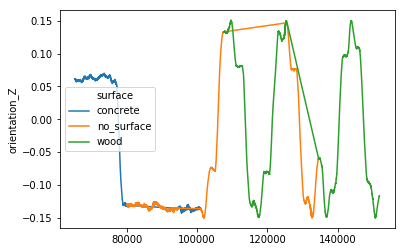

In [65]:
g = sorted_data.groupby('new_group_id')
error_group = g.get_group(2)
sns.lineplot(x = error_group.index,y='orientation_Z',data = error_group, hue='surface');

Some of the series were assigned surfaces because of the stitching, but about 30% of the series still need to be classified. Luckily, the majority of those series are stitched together into sets much longer than 1 series. I will classify each series individually, but then rely on the majority classification to make the final decision. If this works well on the training set then I can import it to the test set.

I'll transform the data first, and then make a test/train set.

In [58]:
reassign = {1:{'surface':'concrete'},2:{'surface':'wood'},3:{'surface':'wood'}}

In [59]:
reassign[1]['start'] = error_group[error_group.surface=='no_surface'].first_valid_index()
reassign[1]['start']

80000

In [60]:
reassign[1]['end'] = error_group.loc[80000:][error_group.loc[80000:].surface == 'concrete'].first_valid_index()
reassign[1]['end']

94592

In [66]:
reassign[2]['start'] = error_group.loc[94592:][error_group.loc[94592:].surface == 'no_surface'].first_valid_index()
reassign[2]['start']

100992

In [67]:
reassign[2]['end'] = error_group.loc[100992:][error_group.loc[100992:].surface == 'wood'].first_valid_index()
reassign[2]['end']

107648

In [68]:
reassign[3]['start'] = error_group.loc[107648:][error_group.loc[107648:].surface == 'no_surface'].first_valid_index()
reassign[3]['start']

125568

In [69]:
reassign[3]['end'] = error_group.loc[125568:][error_group.loc[125568:].surface == 'wood'].first_valid_index()
reassign[3]['end']

134528

In [70]:
reassign

{1: {'surface': 'concrete', 'start': 80000, 'end': 94592},
 2: {'surface': 'wood', 'end': 107648, 'start': 100992},
 3: {'surface': 'wood', 'start': 125568, 'end': 134528}}

In [74]:
for key,value in reassign.items():
    sorted_data.iloc[value['start']:value['end'],1] = value['surface']

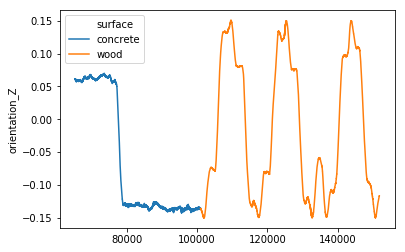

In [75]:
g = sorted_data.groupby('new_group_id')
error_group = g.get_group(2)
sns.lineplot(x = error_group.index,y='orientation_Z',data = error_group, hue='surface');

Export the current matches to check their validity with Kaggle

In [76]:
groups = sorted_data[sorted_data.test == 1].groupby('orig_id')
data = {'series_id':[],'surface':[]}
for name, group in groups:
    data['series_id'].append(name)
    data['surface'].append(group.surface.iloc[0])
output = pd.DataFrame(data)
output.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles


In [77]:
output.to_csv(path_or_buf = 'Submission4_preClassification.csv', 
              header = ['series_id','surface'],index=False)

In [78]:
train_data = sorted_data[sorted_data.surface != 'no_surface']

I need to engineer some features. Below are some functions to help me engineer these features.

In [79]:
def rms(data):
    squared = np.square(data)
    mean = np.mean(squared)
    rms = np.sqrt(mean)
    return rms

In [556]:
surfaces = list(data.surface.unique())
@interact_manual
def plot_series(surface = surfaces, feature = features, center = (-12,12,0.1), width = (0.1,12,0.1), differencing = False):
    surface_name = surface
    surface = train_data.loc[train_data.surface == surface]
    g = surface.groupby('new_group_id')
    series = list(g.groups.keys())
    plt.figure(figsize=(15,15))
    for i,key in enumerate(series[0:4]):
        ax = plt.subplot(2,2,(i+1))
        if not differencing:
            signal = g.get_group(key)[feature].values
            title = surface_name.title().replace('_',' ')
        else:
            RMS = rms(g.get_group(key)[feature].diff(periods=1).dropna())
            title = '{0}\nRMS: {1:1.3f}'.format(surface_name.title().replace('_',' '),RMS)
            signal = g.get_group(key)[feature].diff(periods=1).values
        ax.plot(signal)
        ax.set_title(title)
        ax.set_ylim((center-width,center+width))

interactive(children=(Dropdown(description='surface', options=('fine_concrete', 'concrete', 'wood', 'soft_tile…

In [557]:
@interact_manual
def plot_psd(surface = surfaces, feature = features, max = (0,15,0.25), differencing = False):
    surface_name = surface
    surface = train_data.loc[train_data.surface == surface]
    g = surface.groupby('new_group_id')
    series = list(g.groups.keys())
    plt.figure(figsize=(12,8))
    for i,key in enumerate(series[0:4]):
        if not differencing:
            signal = g.get_group(key)[feature].values
            title = surface_name.title().replace('_',' ')
            freq,psd = welch(signal)
        else:
            RMS = rms(g.get_group(key)[feature].diff(periods=1).dropna())
            title = '{0}\nRMS: {1:1.3f}'.format(surface_name.title().replace('_',' '),RMS)
            signal = g.get_group(key)[feature].diff(periods=1).values
            freq,psd = welch(signal)
        plt.plot(freq,psd)
    plt.title(title)
    plt.ylim((0,max))

interactive(children=(Dropdown(description='surface', options=('fine_concrete', 'concrete', 'wood', 'soft_tile…

The following is a description of the motion of the robot for each feature:<br>
**angular_velocity_X:** How the robot wobbles front-to-back<br>
**angular_velocity_Y:** How the robot wobbles left-to-right<br>
**angular_velocity_Z:** How the robot pivots as it moves (one side advancing faster than the other momentarily)<br>
**linear_acceleration_X:** How the robot strafes/skips left-to-right<br>
**linear_acceleration_Y:** How the robot skips forwards-and-backwards (or how it slips and grips)<br>
**linear_acceleration_Z:** How the robot bounces up-and-down<br>

It appears that every feature has a somewhat unique "jitter" (peak in the PSD) for a given surface. Calculating this jitter allows me to transform the data from a time-domain to a frequency-domain, which reduces each run down to a single set of numbers.

In [581]:
def scalogram(data, title = None):
    bottom = 0

    vmin = min(map(lambda x: min(abs(x)), data))
    vmax = max(map(lambda x: max(abs(x)), data))

    plt.figure(figsize = (12,8))
    #plt.set_autoscale_on(False)
    for row in range(0, len(data)):
        scale = 2.0 ** (row - len(data))

        plt.imshow(
            np.array([abs(data[row])]),
            interpolation = 'spline36',
            vmin = vmin,
            vmax = vmax,
            extent = [0, 1, bottom, bottom + scale])

        bottom += scale
    plt.colorbar()
    plt.ylim(0,bottom)
    if title:
        plt.title(title)

In [585]:
@interact
def plt_scalogram(series_id = sorted_data.series_id.unique()):
    t1 = sorted_data[sorted_data.series_id==series_id]
    coeffs = pywt.wavedec(t1.angular_velocity_X,'bior1.3',level = 4)
    #coeffs[-1] = np.zeros_like(coeffs[-1])
    scalogram(coeffs, title = t1.surface.iloc[0])

interactive(children=(Dropdown(description='series_id', options=(5177, 5243, 5873, 5521, 6817, 6955, 7504, 559…

In [81]:
g = train_data.groupby('series_id')
series = list(g.groups.keys())
data = {}
data['series_id'] = []
data['new_group_id'] = []
data['surface'] = []
for s_key in series:
    data['series_id'].append(s_key)
    data['new_group_id'].append(g.get_group(s_key)['new_group_id'].iloc[0])
    data['surface'].append(g.get_group(s_key)['surface'].iloc[0])
    for feature in features:
        # Get signal
        signal = g.get_group(s_key)[feature]
        signald = signal.diff(1).dropna()
        # Set dictionary keys for time-based features
        range_key = '{0}_range'.format(feature)
        RMS_key = '{0}_RMS'.format(feature)
        std_key = '{0}_std'.format(feature)
        entropy_key = '{0}_entropy'.format(feature)
        zc_key = '{0}_zc'.format(feature)
        if range_key not in data.keys():
            data[range_key] = []
            data[RMS_key] = []
            data[std_key] = []
            data[entropy_key] = []
            data[zc_key] = []
        # Write time-based features
        data[range_key].append(signald.max()-signald.min())
        data[RMS_key].append(rms(signald))
        data[std_key].append(signald.std())
        data[zc_key].append(zero_crossing_rate(np.array(signald)))
        # Calculate entropy (PSD is needed for entropy)
        _,psd_values = welch(signal, nperseg = 64)
        psd_values_normalized = psd_values/psd_values.sum()
        entropy = -np.sum([i*np.log(i) for i in psd_values_normalized])
        data[entropy_key].append(entropy)
        coeffs = pywt.wavedec(signal,'bior1.3',1)
        coeffs_ravel = pywt.ravel_coeffs(coeffs)
        # Store coeff values
        for i,value in enumerate(coeffs_ravel[0]):
            # Store datum
            y_key = '{0}_wt_{1}'.format(feature,i)
            if y_key not in data.keys():
                data[y_key] = []
            data[y_key].append(value)
        # Store psd values
        for i,value in enumerate(psd_values):
            # Store datum
            y_key = '{0}_psd_{1}'.format(feature,i)
            if y_key not in data.keys():
                data[y_key] = []
            data[y_key].append(value)

In [82]:
df2 = pd.DataFrame(data)

In [83]:
X = df2.drop(labels = ['surface'], axis = 1)
y = df2.surface
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.drop(labels = ['new_group_id','series_id'], axis = 1,inplace=True)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Scale the data

In [89]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test[X_train.columns])

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


Perform a random forest classification

In [91]:
RFC = RandomForestClassifier(n_estimators=1000, random_state = 42, n_jobs=-1)
RFC.fit(X_train_scaled, y_train)
#print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
#print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
y_test_RFC = RFC.predict(X_test_scaled)
print(classification_report(y_test, y_test_RFC))

                        precision    recall  f1-score   support

                carpet       0.87      0.23      0.37        86
              concrete       0.49      0.82      0.61       305
         fine_concrete       0.48      0.19      0.27       203
            hard_tiles       1.00      0.05      0.10        38
hard_tiles_large_space       0.81      0.45      0.58       169
              soft_pvc       0.55      0.84      0.67       326
            soft_tiles       0.75      0.88      0.81       136
                 tiled       0.51      0.32      0.39       173
                  wood       0.63      0.54      0.58       252

             micro avg       0.58      0.58      0.58      1688
             macro avg       0.68      0.48      0.49      1688
          weighted avg       0.61      0.58      0.54      1688



Now perform Naive Bayes 

In [95]:
NB = GaussianNB()
NB.fit(X_train_scaled, y_train)
y_test_NB = NB.predict(X_test_scaled)
print(classification_report(y_test, y_test_NB))

                        precision    recall  f1-score   support

                carpet       0.14      0.01      0.02        86
              concrete       0.44      0.06      0.10       305
         fine_concrete       0.25      0.30      0.28       203
            hard_tiles       0.12      0.87      0.21        38
hard_tiles_large_space       0.45      0.42      0.43       169
              soft_pvc       0.47      0.51      0.49       326
            soft_tiles       0.51      0.93      0.66       136
                 tiled       0.29      0.55      0.38       173
                  wood       0.07      0.01      0.01       252

             micro avg       0.34      0.34      0.34      1688
             macro avg       0.30      0.41      0.29      1688
          weighted avg       0.34      0.34      0.29      1688



Now perform RBF SVM

In [103]:
C_range = np.logspace(-4, 0, 8)
param_grid = dict(C=C_range)
grid = GridSearchCV(SVC(kernel = 'linear'), param_grid=param_grid, n_jobs=-1, pre_dispatch=8 )
grid.fit(X_train_scaled, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The best parameters are {'C': 0.005179474679231213} with a score of 0.45


In [104]:
y_test_SVC = grid.predict(X_test_scaled)
print(classification_report(y_test, y_test_SVC))

                        precision    recall  f1-score   support

                carpet       0.15      0.06      0.08        86
              concrete       0.48      0.63      0.54       305
         fine_concrete       0.28      0.17      0.21       203
            hard_tiles       0.00      0.00      0.00        38
hard_tiles_large_space       0.46      0.22      0.30       169
              soft_pvc       0.43      0.72      0.54       326
            soft_tiles       0.58      0.82      0.68       136
                 tiled       0.42      0.33      0.37       173
                  wood       0.45      0.32      0.37       252

             micro avg       0.45      0.45      0.45      1688
             macro avg       0.36      0.36      0.34      1688
          weighted avg       0.41      0.45      0.41      1688



/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Now perform KNN

In [101]:
knn = KNeighborsClassifier(3)
knn.fit(X_train_scaled,y_train)
y_test_knn = knn.predict(X_test_scaled)
print(classification_report(y_test, y_test_knn))

                        precision    recall  f1-score   support

                carpet       0.09      0.20      0.13        86
              concrete       0.27      0.11      0.15       305
         fine_concrete       0.12      0.11      0.12       203
            hard_tiles       0.05      0.08      0.06        38
hard_tiles_large_space       0.24      0.05      0.08       169
              soft_pvc       0.20      0.26      0.23       326
            soft_tiles       0.28      0.93      0.43       136
                 tiled       0.14      0.02      0.03       173
                  wood       0.34      0.27      0.30       252

             micro avg       0.22      0.22      0.22      1688
             macro avg       0.19      0.22      0.17      1688
          weighted avg       0.22      0.22      0.18      1688



In [102]:
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled,y_train)
y_test_dt = dt.predict(X_test_scaled)
print(classification_report(y_test, y_test_dt))

                        precision    recall  f1-score   support

                carpet       0.20      0.26      0.22        86
              concrete       0.49      0.48      0.48       305
         fine_concrete       0.34      0.31      0.32       203
            hard_tiles       0.16      0.16      0.16        38
hard_tiles_large_space       0.48      0.40      0.44       169
              soft_pvc       0.54      0.58      0.56       326
            soft_tiles       0.78      0.75      0.77       136
                 tiled       0.31      0.35      0.33       173
                  wood       0.51      0.48      0.49       252

             micro avg       0.46      0.46      0.46      1688
             macro avg       0.42      0.42      0.42      1688
          weighted avg       0.47      0.46      0.46      1688



In [128]:
X_classified.head()

,new_group_id,angular_velocity_X_range,angular_velocity_X_RMS,angular_velocity_X_std,angular_velocity_X_entropy,angular_velocity_X_zc,angular_velocity_X_wt_0,angular_velocity_X_wt_1,angular_velocity_X_wt_2,angular_velocity_X_wt_3,...,linear_acceleration_Z_psd_27,linear_acceleration_Z_psd_28,linear_acceleration_Z_psd_29,linear_acceleration_Z_psd_30,linear_acceleration_Z_psd_31,linear_acceleration_Z_psd_32,surface_RFC,surface_dt,surface_SVC,new_surface
series_id,,,,,,,,,,,,,,,,,,,,,
7001,52,0.298564,0.066695,0.066958,2.020823,[[0.0224609375]],-0.270240,-0.270240,-0.159282,-0.018233,...,0.703798,0.586422,0.469260,0.798356,1.909104,1.029526,concrete,concrete,concrete,soft_pvc
5872,55,0.556702,0.118909,0.119372,1.831078,[[0.02197265625]],-0.384306,-0.384306,-0.148238,-0.098614,...,1.808227,0.905517,0.614614,0.782162,0.460367,0.237662,tiled,fine_concrete,concrete,soft_pvc
5340,43,0.076305,0.015312,0.015370,1.910724,[[0.0244140625]],-0.136348,-0.136348,-0.068584,0.153171,...,0.025949,0.015395,0.018110,0.026306,0.029809,0.014406,carpet,carpet,soft_pvc,soft_pvc
2465,52,0.125535,0.022293,0.022381,2.384093,[[0.0205078125]],-0.064767,-0.064767,-0.001094,0.111885,...,0.013257,0.126000,0.186108,0.181294,0.127508,0.014898,wood,carpet,soft_pvc,soft_pvc
2348,48,0.244297,0.052295,0.052495,1.982108,[[0.02294921875]],-0.401550,-0.401550,-0.200207,0.279164,...,0.247497,0.194647,0.193837,0.339354,0.303204,0.011178,soft_pvc,fine_concrete,soft_pvc,soft_pvc


In [ ]:
X_classified = X_test.copy()
X_classified['surface']  = y_test_RFC
groups = X_classified.groupby('new_group_id')
reclassified_dfs = []
for name,group in groups:
    surface = group.surface.value_counts().index[0]
    group.surface = surface
    reclassified_dfs.append(group)
reclassified = pd.concat(reclassified_dfs)
X_classified.set_index('series_id',inplace = True)
reclassified.set_index('series_id',inplace=True)
X_classified['new_surface'] = reclassified.surface
print(classification_report(y_test, X_classified.new_surface))

In [179]:
X_classified = X_test.copy()
X_classified['surface'] = y_test_RFC
X_classified['surface_RFC']  = y_test_RFC
X_classified['surface_dt'] = y_test_dt
X_classified['surface_SVC'] = y_test_SVC
X_classified['surface_knn'] = y_test_knn
groups = X_classified.groupby('new_group_id')
reclassified_dfs = []
sanity_check = 0
for name,group in groups:
    a=group.surface_RFC.value_counts()
    b=group.surface_dt.value_counts()
    c=group.surface_SVC.value_counts()
    d=group.surface_knn.value_counts()
    all_predictors = pd.DataFrame([a*1.,b*8,c*0.8]).fillna(value=0)
    surface1 = all_predictors.sum().sort_values(ascending=False).index[0]
    #surface = group.surface_RFC.value_counts().index[0]
    group.surface = surface1
    reclassified_dfs.append(group)
reclassified = pd.concat(reclassified_dfs)
X_classified.set_index('series_id',inplace = True)
reclassified.set_index('series_id',inplace=True)
X_classified['new_surface'] = reclassified.surface
print(classification_report(y_test, X_classified.new_surface))

/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


                        precision    recall  f1-score   support

                carpet       0.57      0.27      0.37        86
              concrete       0.62      0.69      0.65       305
         fine_concrete       1.00      0.33      0.50       203
            hard_tiles       0.00      0.00      0.00        38
hard_tiles_large_space       0.93      0.94      0.94       169
              soft_pvc       0.64      1.00      0.78       326
            soft_tiles       0.90      0.97      0.93       136
                 tiled       1.00      0.89      0.94       173
                  wood       0.76      0.79      0.77       252

             micro avg       0.75      0.75      0.75      1688
             macro avg       0.71      0.65      0.65      1688
          weighted avg       0.77      0.75      0.73      1688



/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [180]:
unclassified_data = sorted_data[sorted_data.surface == 'no_surface']
g = unclassified_data.groupby('series_id')
series = list(g.groups.keys())
data = {}
data['series_id'] = []
data['new_group_id'] = []
data['surface'] = []
for s_key in series:
    data['series_id'].append(s_key)
    data['new_group_id'].append(g.get_group(s_key)['new_group_id'].iloc[0])
    data['surface'].append(g.get_group(s_key)['surface'].iloc[0])
    for feature in features:
        # Get signal
        signal = g.get_group(s_key)[feature]
        signald = signal.diff(1).dropna()
        # Set dictionary keys for time-based features
        range_key = '{0}_range'.format(feature)
        RMS_key = '{0}_RMS'.format(feature)
        std_key = '{0}_std'.format(feature)
        entropy_key = '{0}_entropy'.format(feature)
        zc_key = '{0}_zc'.format(feature)
        if range_key not in data.keys():
            data[range_key] = []
            data[RMS_key] = []
            data[std_key] = []
            data[entropy_key] = []
            data[zc_key] = []
        # Write time-based features
        data[range_key].append(signald.max()-signald.min())
        data[RMS_key].append(rms(signald))
        data[std_key].append(signald.std())
        data[zc_key].append(zero_crossing_rate(np.array(signald)))
        # Calculate entropy (PSD is needed for entropy)
        _,psd_values = welch(signal, nperseg = 64)
        psd_values_normalized = psd_values/psd_values.sum()
        entropy = -np.sum([i*np.log(i) for i in psd_values_normalized])
        data[entropy_key].append(entropy)
        coeffs = pywt.wavedec(signal,'bior1.3',1)
        coeffs_ravel = pywt.ravel_coeffs(coeffs)
        # Store coeff values
        for i,value in enumerate(coeffs_ravel[0]):
            # Store datum
            y_key = '{0}_wt_{1}'.format(feature,i)
            if y_key not in data.keys():
                data[y_key] = []
            data[y_key].append(value)
        # Store psd values
        for i,value in enumerate(psd_values):
            # Store datum
            y_key = '{0}_psd_{1}'.format(feature,i)
            if y_key not in data.keys():
                data[y_key] = []
            data[y_key].append(value)

In [181]:
df2 = pd.DataFrame(data)

In [191]:
df2.head()

,series_id,new_group_id,surface,angular_velocity_X_range,angular_velocity_X_RMS,angular_velocity_X_std,angular_velocity_X_entropy,angular_velocity_X_zc,angular_velocity_X_wt_0,angular_velocity_X_wt_1,...,linear_acceleration_Z_psd_23,linear_acceleration_Z_psd_24,linear_acceleration_Z_psd_25,linear_acceleration_Z_psd_26,linear_acceleration_Z_psd_27,linear_acceleration_Z_psd_28,linear_acceleration_Z_psd_29,linear_acceleration_Z_psd_30,linear_acceleration_Z_psd_31,linear_acceleration_Z_psd_32
0,3819,68,no_surface,0.121048,0.020779,0.020861,2.170300,[[0.0224609375]],0.037937,0.037937,...,0.047384,0.035123,0.123213,0.121220,0.043762,0.003189,0.013132,0.026850,0.030976,0.022641
1,3824,69,no_surface,0.533420,0.123769,0.124251,1.983230,[[0.02099609375]],-0.365575,-0.365575,...,0.130021,0.471948,1.128349,0.577118,0.850059,0.460736,0.641222,0.611456,0.653173,0.550795
2,3827,70,no_surface,0.063668,0.012373,0.012419,1.156204,[[0.02099609375]],-0.087619,-0.087619,...,0.004533,0.004884,0.001117,0.003082,0.007722,0.004456,0.004640,0.003559,0.003519,0.000407
3,3839,71,no_surface,0.830419,0.158192,0.158727,1.473526,[[0.0205078125]],-0.130816,-0.130816,...,0.161411,0.310410,0.614138,0.917174,0.654474,0.650984,0.606910,0.508776,0.605943,0.026696
4,3841,72,no_surface,0.059549,0.014304,0.014360,1.844316,[[0.02392578125]],0.000546,0.000546,...,0.050571,0.068961,0.054637,0.028042,0.017628,0.014009,0.010959,0.022413,0.015784,0.005963


In [195]:
X = df2.drop(labels = ['surface'], axis = 1)
X_test_scaled = scaler.transform(X[X_train.columns])
y_test_RFC = RFC.predict(X_test_scaled)
y_test_dt = dt.predict(X_test_scaled)
y_test_SVC = grid.predict(X_test_scaled)
X_classified = X.copy()
X_classified['surface'] = y_test_RFC
X_classified['surface_RFC']  = y_test_RFC
X_classified['surface_dt'] = y_test_dt
X_classified['surface_SVC'] = y_test_SVC
groups = X_classified.groupby('new_group_id')
reclassified_dfs = []
sanity_check = 0
for name,group in groups:
    a=group.surface_RFC.value_counts()
    b=group.surface_dt.value_counts()
    c=group.surface_SVC.value_counts()
    all_predictors = pd.DataFrame([a*1.,b*8,c*0.8]).fillna(value=0)
    surface1 = all_predictors.sum().sort_values(ascending=False).index[0]
    #surface = group.surface_RFC.value_counts().index[0]
    group.surface = surface1
    reclassified_dfs.append(group)
reclassified = pd.concat(reclassified_dfs)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  
/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [196]:
a = sorted_data.copy()
for index,row in reclassified.iterrows():
    a.loc[a.series_id==row.series_id, 'surface'] = row.surface

In [197]:
a.surface.value_counts()

soft_pvc                  195712
concrete                  183424
wood                      145408
tiled                     115840
fine_concrete             102528
soft_tiles                 89216
hard_tiles_large_space     77440
carpet                     50048
hard_tiles                 16512
Name: surface, dtype: int64

In [198]:
a.head()

,series_id,surface,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,orig_id,test,new_group_id
0,5177,fine_concrete,0,0.97167,-0.18258,-0.019701,0.14876,0.003953,0.031351,-0.086012,0.070510,2.8750,-9.3821,1367,1,0
1,5177,fine_concrete,1,0.97169,-0.18247,-0.019699,0.14874,0.003299,0.028777,-0.090271,0.091805,2.8709,-9.3610,1367,1,0
2,5177,fine_concrete,2,0.97172,-0.18236,-0.019674,0.14874,0.010289,0.032158,-0.086130,0.115780,2.8979,-9.3569,1367,1,0
3,5177,fine_concrete,3,0.97174,-0.18225,-0.019646,0.14874,0.003284,0.035404,-0.088382,0.087879,2.8695,-9.3584,1367,1,0
4,5177,fine_concrete,4,0.97176,-0.18214,-0.019614,0.14874,0.006005,0.038119,-0.084560,0.121400,2.8646,-9.3847,1367,1,0


In [199]:
X_test_matched = a.loc[a.series_id > df.series_id.max()]

In [200]:
groups = X_test_matched.groupby('orig_id')
data = {'series_id':[],'surface':[]}
for name, group in groups:
    data['series_id'].append(name)
    data['surface'].append(group.surface.iloc[0])
output = pd.DataFrame(data)
output.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles


In [201]:
output.to_csv(path_or_buf = 'Submission4_classified.csv', header = ['series_id','surface'],index=False)